# CMB-S4 Instrumentation Summer School
## Holography Lab Notebook #2: Beam Systematic Estimation

Authors: Sara M. Simon

In this notebook, we will propagate beam systematics into power spectrum leakage.

In [39]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from numpy import genfromtxt
from matplotlib.pyplot import rc
import scipy.optimize as opt

The feedhorn couples light onto the ortho-mode transducer (the four fins in the photo), which splits the power into two orthogaonal (x and y) polarizations.

<img src="cmb_spectra/Argonne_det.jpg" width=800 height=800 />

First we will make an elliptical 2D Gaussian beam for both the x and y polarizations of the detector. In a perfectly symmetric horn, the y polarization is identical to the x polarizaton but is rotated by 90 degrees.

### Calculating the Farfield Beam

ellipticity =  -0.14285714285714285


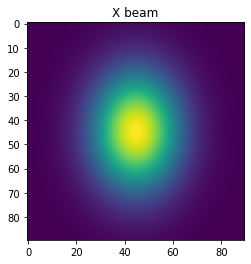

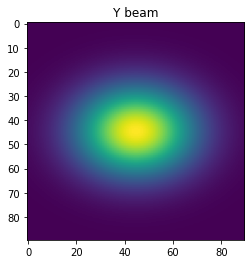

In [40]:
FWHM_x=30 #degrees
FWHM_y=40 #degrees
print('ellipticity = ', (FWHM_x-FWHM_y)/(FWHM_x+FWHM_y))
x=np.linspace(-44.5,44.5,90) #degrees
y=np.linspace(-44.5,44.5,90) #degrees
x_1,y_1=np.meshgrid(x,-1*y)

wx=FWHM_x/np.sqrt(2*np.log(2))
wy=FWHM_y/np.sqrt(2*np.log(2))

#x-polarization
beam_un_x = np.exp(-2*(x_1**2/wx**2+y_1**2/wy**2))
#normalize
beam_x=beam_un_x/np.max(beam_un_x)
plt.imshow(beam_x)
plt.title("X beam")
plt.show()

#y-polarization
beam_un_y = np.exp(-2*(y_1**2/wx**2+x_1**2/wy**2))
#normalize
beam_y=beam_un_y/np.max(beam_un_y)
plt.imshow(beam_y)
plt.title("Y beam")
plt.show()

The feedhorn beams interact with the Lyot stop in the optics. For the LATs this is around 13 degrees. Below we convolve the beam with the stop to get the farfield beams. Play around with the stop size and see what happens to the beam shapes. The output of this will give us our x and y polarization beams in the farfield.

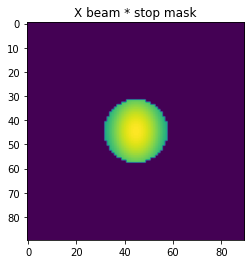

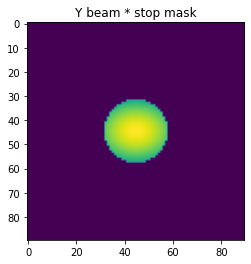

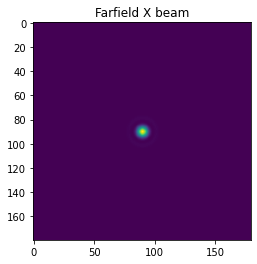

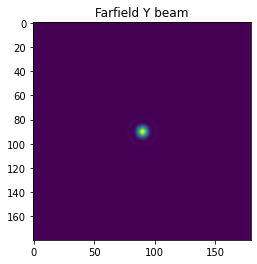

In [44]:
stop_angle=13.
#make a mask of the stop with 1 inside the stop and zero outside
telecentricity=0
cen=44.5
center=[cen-telecentricity,cen]
radius = stop_angle
YY, XX = np.ogrid[:90, :90]
dist_from_center = np.sqrt((XX - center[0])**2 + (YY-center[1])**2)
mask = (dist_from_center <= radius)*1

#multiply the beams by the mask
beam_x_stop=beam_x*mask
beam_y_stop=beam_y*mask
plt.title("X beam * stop mask")
plt.imshow(beam_x_stop)
plt.show()
plt.title("Y beam * stop mask")
plt.imshow(beam_y_stop)
plt.show()

###Do a Fourier Transform to convolve the beam with the stop to get the farfield beam###

#fft shift the magnitude of the beam to the corners
beam_x_stop=np.fft.fftshift(np.sqrt(beam_x_stop))
beam_y_stop=np.fft.fftshift(np.sqrt(beam_y_stop))

#zero pad
n_pix=180
n_half=int(n_pix/2)
n_edge=n_pix-45

magx=np.zeros((n_pix,n_pix))
magy=np.zeros((n_pix,n_pix))

magx[0:45,0:45]=beam_x_stop[0:45,0:45]
magx[0:45,n_edge:n_pix]=beam_x_stop[0:45,45:90]
magx[n_edge:n_pix,0:45]=beam_x_stop[45:90,0:45]
magx[n_edge:n_pix,n_edge:n_pix]=beam_x_stop[45:90,45:90]

magy[0:45,0:45]=beam_y_stop[0:45,0:45]
magy[0:45,n_edge:n_pix]=beam_y_stop[0:45,45:90]
magy[n_edge:n_pix,0:45]=beam_y_stop[45:90,0:45]
magy[n_edge:n_pix,n_edge:n_pix]=beam_y_stop[45:90,45:90]



#perform the FFT
fft_magx_complex=np.fft.fft2(magx)
fft_magy_complex=np.fft.fft2(magy)

powx_fft=np.real(fft_magx_complex)**2+np.imag(fft_magx_complex)**2
beam_x_conv=np.fft.fftshift(powx_fft)
powy_fft=np.real(fft_magy_complex)**2+np.imag(fft_magy_complex)**2
beam_y_conv=np.fft.fftshift(powy_fft)


plt.imshow(beam_x_conv)
plt.title("Farfield X beam")
plt.show()
plt.imshow(beam_y_conv)
plt.title("Farfield Y beam")
plt.show()

As you can see, convolving with the stop symmetrizes the beam more. The smaller the stop, the less ellipticity you get. But this also means you get less of the total beam power through the stop. When we design the instrument, we have to weigh the sensitivity (power) versus the sytematic effects.

### Calculating the Leakage Beams

To estimate the effect of these beams on the power spectrum, we will need to calculate the leakage beams. The electric fields on the sky $E_x$ and $E_y$ are coupled to the electric field in the detectors $E_a$ and $E_b$ by:

$$
  \begin{bmatrix}
  E_a\\
  E_b
  \end{bmatrix}
  =
  \begin{bmatrix}
  \beta_{ax} & \beta_{ay}\\
  \beta_{bx} & \beta_{by}
  \end{bmatrix}
  \begin{bmatrix}
  E_x\\
  E_y
  \end{bmatrix}
  \,\,\, , $$

where $a$ and $x$ as well as $b$ and $y$ are aligned along the telescope boresight. Here $\beta_{ax}$ and $\beta_{by}$ are the co-polar beams, and $\beta_{ay}$ and $\beta_{bx}$ are the cross-polar beams.


To measure the polarized signal $P$ from the CMB, we difference the two orthogonal polarization signals:
\begin{equation}
P=E_a^2-E_b^2 \,\,\,\,.
\end{equation}

The Stokes parameters using the decreasing phase convention are given by
$$\begin{align}
I & =  |E_{x}|^2+ |E_{y}|^2  \\
Q & =   |E_{x}|^2- |E_{y}|^2  \\
U & =  2\,\mathrm{Re}(E_{x} E_{y}^{*}) \\
V & =  2\,\mathrm{Im}(E_{x} E_{y}^{*})\,\,\,\,\,.
\end{align}$$
Here $I$ is the intensity, $Q$ and $U$ describe the linear polarization, and $V$ describes the circular polarization.

From this, we can derive the leakage beams:

$$P=\sigma I + \delta Q + \epsilon U+ \gamma V\,\,\,\, ,$$


where the coefficients are the beam couplings from $I$, $Q$, $U$, and $V$ into $P$. The beam couplings are then given by
\begin{align}
\sigma & =  \frac{1}{2} (\beta_{ax}^2 + \beta_{ay}^2 - \beta_{bx}^2 - \beta_{by}^2) \\ 
\delta & =   \frac{1}{2} (\beta_{ax}^2 - \beta_{ay}^2 - \beta_{bx}^2 + \beta_{by}^2) \\
\epsilon & =  \mathrm{Re}(\beta_{ax}^{*} \beta_{ay} - \beta_{bx}\beta_{by}^{*} )  \\
\gamma & =  -\mathrm{Im}(\beta_{ax} \beta_{ay}^{*} + \beta_{bx}^{*}\beta_{by} )\,\,\,\,\,.
\end{align}

$\sigma$ is the temperature to polarization leakage, $\delta$ is the polarized beam, $\epsilon$ is the E-mode to B-mode leakage, and $\gamma$ is the linear to circular polarization leakage.

For this simulation, we will assume that our cross-polar beams are rotationally symmetric, which means that $\beta_{ay}=\beta_{bx}$. Additionally, in this notebook, we will only look at the main beam $\delta$ and the temperature to polarization leakage beam $\sigma$ since the leakage from E-modes to B-mode and circular polarization is negligible.

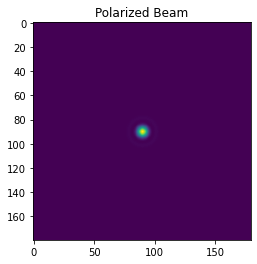

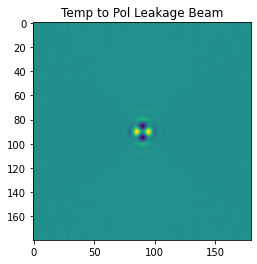

In [45]:
#main beam (delta)
Q=1/2*(beam_x_conv+beam_y_conv)
plt.imshow(Q)
plt.title("Polarized Beam")
plt.show()

#Temperature to polarization leakage beam (sigma)
I=1/2*(beam_x_conv-beam_y_conv)
plt.imshow(I)
plt.title("Temp to Pol Leakage Beam")
plt.show()

You can see that the temperature to polarization leakage is quadrupolar as you'd expect from differencing two orthogonal elliptical beams.

### Calculating the leakage into the power spectrum

To calculate the leakage into the power spectrum, we can estimate the window function of the beam by taking the Fourier Transform and then radially binning. We can then multiply this window function by the power spectra to estimate the effect of the beams. This is an overly simplistic treatment, but gives a good upper limit of the effect.

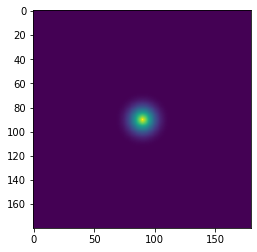

/tmp/ipykernel_3303101/205424475.py:72: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(0,10000)


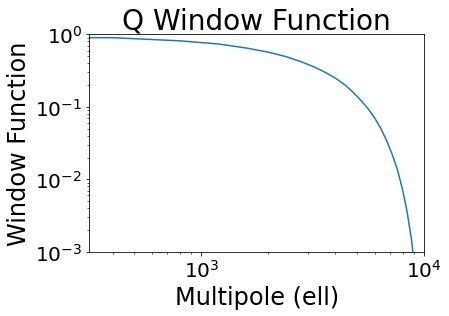

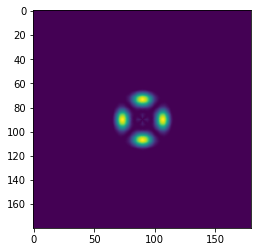

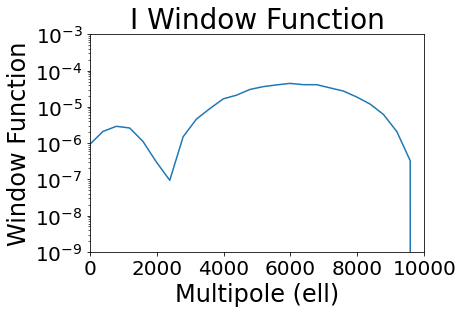

In [46]:
#First we define the beam size through the telescope optics using the equation for a diffraction limited system

#aperture in cm
D = 550.
center_frequency=90. #GHz
on_sky_beam=(1.220*29.98*180.*60.)/(center_frequency*D*np.pi)  #diffraction limited system equation.


#Do a Fourier Transform
Q_t=np.fft.fftshift(Q)
I_t=np.fft.fftshift(I)

fft_Q=np.fft.fft2(Q_t)
fft_I=np.fft.fft2(I_t)

#calculate the magnitude squared
Q_fft=np.real(fft_Q)**2+np.imag(fft_Q)**2
Q_mag=np.fft.fftshift(Q_fft)
I_fft=np.real(fft_I)**2+np.imag(fft_I)**2
I_mag=np.fft.fftshift(I_fft)

#normalize
Q_m=Q_mag/np.max(Q_mag)
I_m=I_mag/np.max(Q_mag)


#Bin radially to make 1D function
y,x = np.indices(Q_m.shape)
center=n_pix/2.
r = np.hypot(x-center, y-center)

# Get sorted radii
ind = np.argsort(r.flat)
r_sorted = r.flat[ind]
Q_sorted = Q_m.flat[ind]
I_sorted = I_m.flat[ind]

# Get the integer part of the radii (bin size = 1)
r_int = r_sorted.astype(int)

# Find all pixels that fall within each radial bin.
deltar = r_int[1:] - r_int[:-1]  # Assumes all radii represented
rind = np.where(deltar)[0]       # location of changed radius
nr = rind[1:] - rind[:-1]        # number of radius bin

Qsim = np.cumsum(Q_sorted, dtype=float)
Qtbin = Qsim[rind[1:]] - Qsim[rind[:-1]]
Isim = np.cumsum(I_sorted, dtype=float)
Itbin = Isim[rind[1:]] - Isim[rind[:-1]]

Qrad = Qtbin / nr
Irad = Itbin / nr

Q_rad=Qrad/np.max(Qrad)
I_rad=Irad/np.max(Qrad)

#Find how krad scales with multipole
kmax=len(Q_rad)
krad=np.linspace(0,kmax-1,kmax)

#res is resolution in degrees
res=1.0
l_rad=krad*np.pi*res*D*center_frequency/(29.98*stop_angle)

#plots
plt.imshow(Q_m)
plt.show()

fig,ax=plt.subplots(1)
plt.loglog(l_rad,Q_rad)
ax.set_ylim(.001,1)
ax.set_xlim(0,10000)
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontsize(20)
ax.set_title('Q Window Function',fontsize=28)
ax.set_xlabel('Multipole (ell)',fontsize=24)
ax.set_ylabel('Window Function',fontsize=24)
plt.show()

plt.imshow(I_m)
plt.show()

fig,ax=plt.subplots(1)
plt.semilogy(l_rad,I_rad)
ax.set_ylim(1.e-9,.001)
ax.set_xlim(0,10000)
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontsize(20)
ax.set_title('I Window Function',fontsize=28)
ax.set_xlabel('Multipole (ell)',fontsize=24)
ax.set_ylabel('Window Function',fontsize=24)
plt.show()

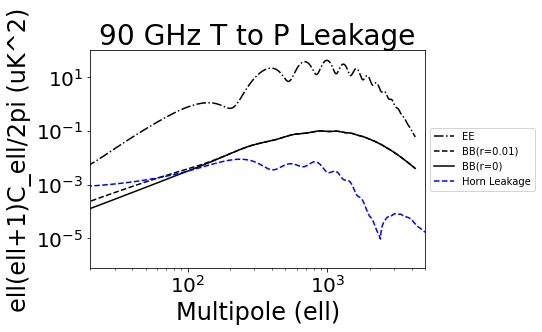

In [47]:
#apply window functions to the spectra to calculate the leakages

#Multiply by CMB spectra
#import spectra
cmbr=np.loadtxt('cmb_spectra/Total_plus_lensed_20160526_r0_01.txt')
cmb=np.loadtxt('cmb_spectra/Total_plus_lensed_20160526_r0.txt')
#temperature is [:,1]
#EE is [:,2]
#BB is [:,3]
tt_ell=np.loadtxt('cmb_spectra/1_7_2015_t_ell.txt')
tt=np.loadtxt('cmb_spectra/1_7_2015_t.txt')
ee_ell=cmbr[:,0]
ee=cmbr[:,2]
bb_ell=cmbr[:,0]
bb=cmbr[:,3]
#r=0 BB (lensed only)
bb_ell_nor=cmb[:,0]
bb_nor=cmb[:,3]

#TT*I Temperature leakage
fig,ax=plt.subplots(1)
#interpolate window function to match ells from TT
ax.loglog(ee_ell,ee,label='EE', linestyle="-.", color='k')
ax.loglog(bb_ell,bb,label='BB(r=0.01)', linestyle="--", color='k')
ax.loglog(bb_ell_nor,bb_nor,label='BB(r=0)', color='k')

I1=np.interp(tt_ell,l_rad, I_rad)
TTI2=I1*tt
ax.loglog(tt_ell,TTI2, color='blue', linestyle="--", label='Horn Leakage')
plt.xlim(20,5000)
lgd=ax.legend(loc='center left',bbox_to_anchor=(1, 0.5))
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontsize(20)
ax.set_title('90 GHz T to P Leakage',fontsize=28)
ax.set_xlabel('Multipole (ell)',fontsize=24)
ax.set_ylabel('ell(ell+1)C_ell/2pi (uK^2)',fontsize=24)
plt.show()

Play around with the ellipticity and see how the leakage level moves around.

Now that we can see the leakage level, let's talk about some of the limitations of our simplistic model:

1. The leakage level at $\ell<100$ is artificially high due to the resolution of the simulation (there is only one point in the window function here).

2. It assumes we don't correct for the known ellipticity of our beam. Calibration goes a long way!

3. It assumes we do raw pair differencing. Experiments like ACT use the polarization angle of the detector to get the polarized signal so do not difference the two detectors. They are thus less susceptible to this effect.

4. It doesn't tell us if the leakage goes into E-modes or B-modes. If you were to do a full, map-based simulation of the beam, you would find that the temperature to polarization leakage of the feedhorns goes almost entirely into E-modes. This is consistent with expectations from the analytical formalism from Shimon, et al. 2008 (https://arxiv.org/pdf/0709.1513.pdf). The feedhorns produce elliptical beams if fed with $E_x$ or $E_y$ polarization. Because the semi-major axes of these beams are orthogonal, the $s_{\psi}^2$ term vanishes and thus the leakage into B-modes vanishes as shown in Table V.

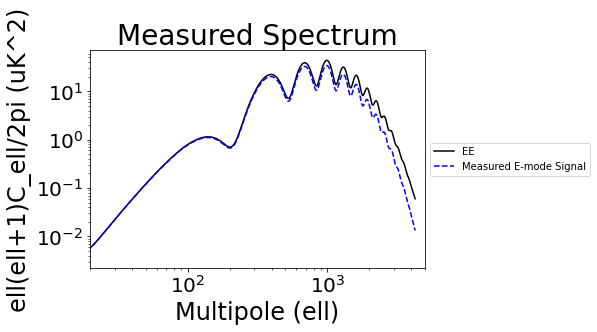

In [48]:
#Main beam
fig,ax=plt.subplots(1)
#interpolate window function to match ells from TT
ax.loglog(ee_ell,ee,label='EE', color='k')

Q1=np.interp(ee_ell,l_rad, Q_rad)
TTQ2=Q1*ee
ax.loglog(ee_ell,TTQ2, color='blue', linestyle="--", label='Measured E-mode Signal')
plt.xlim(20,5000)
lgd=ax.legend(loc='center left',bbox_to_anchor=(1, 0.5))
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontsize(20)
ax.set_title('Measured Spectrum',fontsize=28)
ax.set_xlabel('Multipole (ell)',fontsize=24)
ax.set_ylabel('ell(ell+1)C_ell/2pi (uK^2)',fontsize=24)
plt.show()

You can see that as we go to higher multipoles, the measured signal starts to diverge--this is due to the beam size. This is showing us that if you have a larger aperture, you can reach higher resolution! This again shows the importance of calibrating our beams well so that we can tell what is the instrument and what is the measurement.